In [7]:
import cv2       # 导入opencv包
import numpy as np   
import matplotlib.pyplot as plt
# 读取需要拼接的图像,注意图像左右的顺序
image_left = cv2.imread("5.jpg")
image_right = cv2.imread("6.jpg")

In [8]:
def sift_keypoints_detect(image):

    # 处理图像一般很少用到彩色信息，通常将图像转换为灰度图
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 获取图像特征sift-SIFT特征点,实例化对象sift
    sift = cv2.xfeatures2d.SIFT_create()

    # keypoints:特征点向量,向量内的每一个元素是一个KeyPoint对象，包含了特征点的各种属性信息(角度、关键特征点坐标等)
    # features:表示输出的sift特征向量，通常是128维的
    keypoints, features = sift.detectAndCompute(image, None)

    """ 
    cv2.drawKeyPoints():在图像的关键特征点部位绘制一个小圆圈。
    如果传递标志flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
    它将绘制一个大小为keypoint的圆圈并显示它的方向。
    这种方法同时显示图像的坐标，大小和方向，是最能显示特征的一种绘制方式。
    """
    keypoints_image = cv2.drawKeypoints(
        gray_image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

    # 返回带关键特征点的图像、关键特征点和sift的特征向量
    return keypoints_image, keypoints, features

In [9]:
# 使用KNN检测来自左右图像的SIFT特征进行匹配
def get_feature_point_ensemble(features_right, features_left):

    # 创建BFMatcher对象解决匹配
    bf = cv2.BFMatcher()

    # knnMatch()函数：返回每个特征点的最佳匹配k个匹配点
    # features_right为模板图，features_left为匹配图
    matches = bf.knnMatch(features_right, features_left, k=2)

    """
    利用sorted()函数对matches对象进行升序(默认)操作,x:x[]字母可以随意修改，
    排序方式按照中括号[]里面的维度进行排序，[0]按照第一维排序，[2]按照第三维排序
    """
    matches = sorted(matches, key=lambda x: x[0].distance / x[1].distance)

    # 建立列表good用于存储匹配的点集
    good = []
    for m, n in matches:
        # ratio的值越大，匹配的线条越密集，但错误匹配点也会增多
        ratio = 0.6
        if m.distance < ratio * n.distance:
            good.append(m)

    # 返回匹配的关键特征点集
    return good

In [10]:
# 计算视角变换矩阵H，用H对右图进行变换并返回全景拼接图像
def Panorama_stitching(image_right, image_left):

    _, keypoints_right, features_right = sift_keypoints_detect(image_right)
    _, keypoints_left, features_left = sift_keypoints_detect(image_left)
    goodMatch = get_feature_point_ensemble(features_right, features_left)

    # 当筛选项的匹配对大于4对(因为homography单应性矩阵的计算需要至少四个点)时,计算视角变换矩阵
    if len(goodMatch) > 4:
        # 获取匹配对的点坐标
        Point_coordinates_right = np.float32(
            [keypoints_right[m.queryIdx].pt for m in goodMatch]).reshape(-1, 1, 2)
        Point_coordinates_left = np.float32(
            [keypoints_left[m.trainIdx].pt for m in goodMatch]).reshape(-1, 1, 2)

        # ransacReprojThreshold：将点对视为内点的最大允许重投影错误阈值(仅用于RANSAC和RHO方法时)
        # 若srcPoints和dstPoints是以像素为单位的，该参数通常设置在1到10的范围内
        ransacReprojThreshold = 4

        # cv2.findHomography():计算多个二维点对之间的最优单映射变换矩阵 H(3行x3列),使用最小均方误差或者RANSAC方法
        # 作用:利用基于RANSAC的鲁棒算法选择最优的四组配对点，再计算转换矩阵H(3*3)并返回,以便于反向投影错误率达到最小
        Homography, status = cv2.findHomography(
            Point_coordinates_right, Point_coordinates_left, cv2.RANSAC, ransacReprojThreshold)

        # cv2.warpPerspective()：透视变换函数，用于解决cv22.warpAffine()不能处理视场和图像不平行的问题
        # 作用：就是对图像进行透视变换，可保持直线不变形，但是平行线可能不再平行
        Panorama = cv2.warpPerspective(
            image_right, Homography, (image_right.shape[1] + image_left.shape[1], image_right.shape[0]))

        # cv2.imshow("扭曲变换后的右图", Panorama)
        plt.rcParams["figure.figsize"] = (20, 10)
        plt.title('transformed right image')
        plt.imshow(Panorama)
        plt.show()
        # 将左图加入到变换后的右图像的左端即获得最终图像
        Panorama[0:image_left.shape[0], 0:image_left.shape[1]] = image_left

        # 返回全景拼接的图像
        return Panorama

In [11]:
image_right = cv2.resize(image_right, None, fx=0.4, fy=0.35)
image_left = cv2.resize(
        image_left, (image_right.shape[1], image_right.shape[0]))

    # 获取检测到关键特征点后的图像的相关参数
keypoints_image_right, keypoints_right, features_right = sift_keypoints_detect(
        image_right)
keypoints_image_left, keypoints_left, features_left = sift_keypoints_detect(
        image_left)


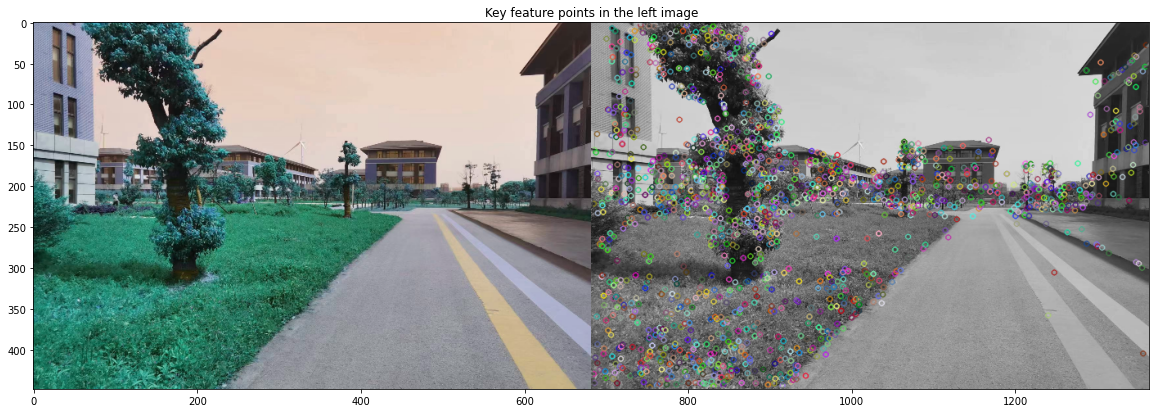

In [12]:

# 利用np.hstack()函数同时将原图和绘有关键特征点的图像沿着竖直方向(水平顺序)堆叠起来
img=np.hstack((image_left, keypoints_image_left))
plt.rcParams["figure.figsize"] = (20, 10)
plt.title('Key feature points in the left image')
plt.imshow(img)
plt.show()

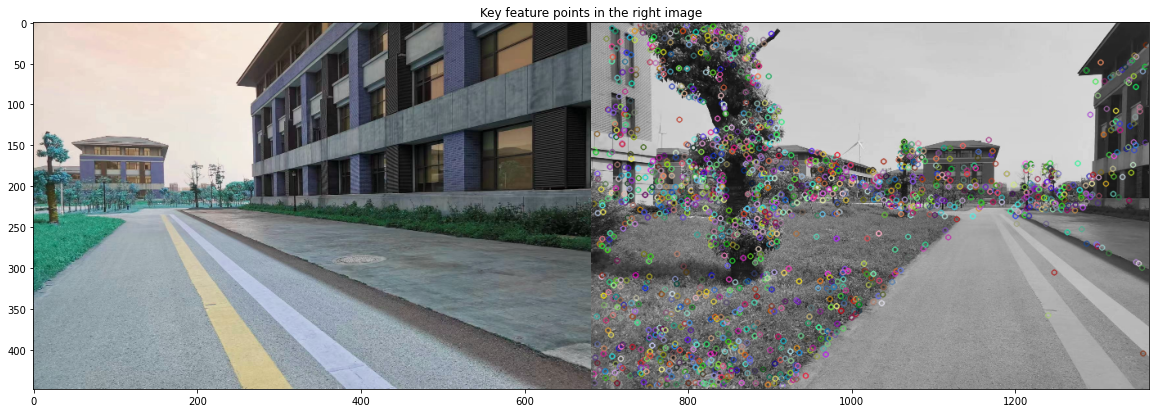

In [13]:
# cv2.imshow("右图关键特征点检测", np.hstack((image_right, keypoints_image_right)))
img=np.hstack((image_right, keypoints_image_left))
plt.rcParams["figure.figsize"] = (20, 10)
plt.title('Key feature points in the right image')
plt.imshow(img)
plt.show()
goodMatch = get_feature_point_ensemble(features_right, features_left)


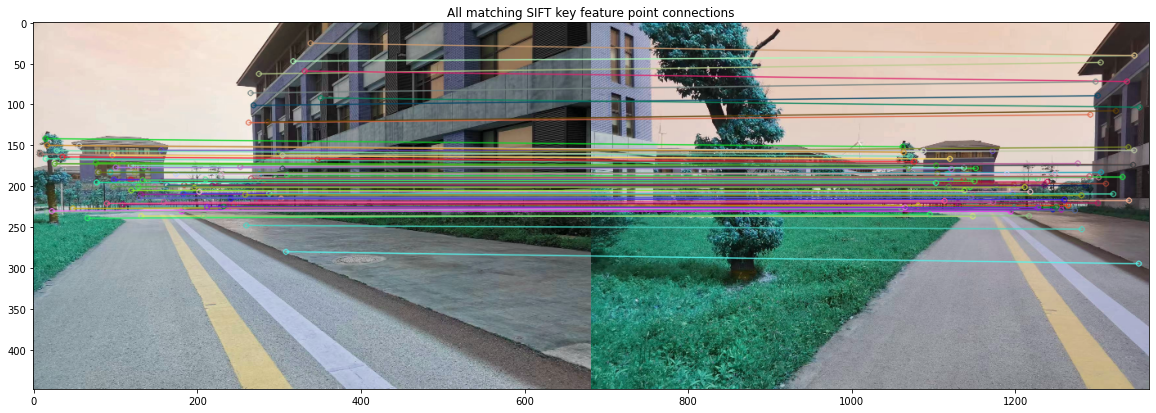

In [14]:
# cv2.drawMatches():在提取两幅图像特征之后，画出匹配点对连线
    # matchColor – 匹配的颜色（特征点和连线),若matchColor==Scalar::all(-1),颜色随机
all_goodmatch_image = cv2.drawMatches(
        image_right, keypoints_right, image_left, keypoints_left, goodMatch, None, None, None, None, flags=2)
# cv2.imshow("所有匹配的SIFT关键特征点连线", )
plt.rcParams["figure.figsize"] = (20, 10)
plt.title('All matching SIFT key feature point connections')
plt.imshow(all_goodmatch_image)
plt.show()
# cv2.destroyAllWindows()

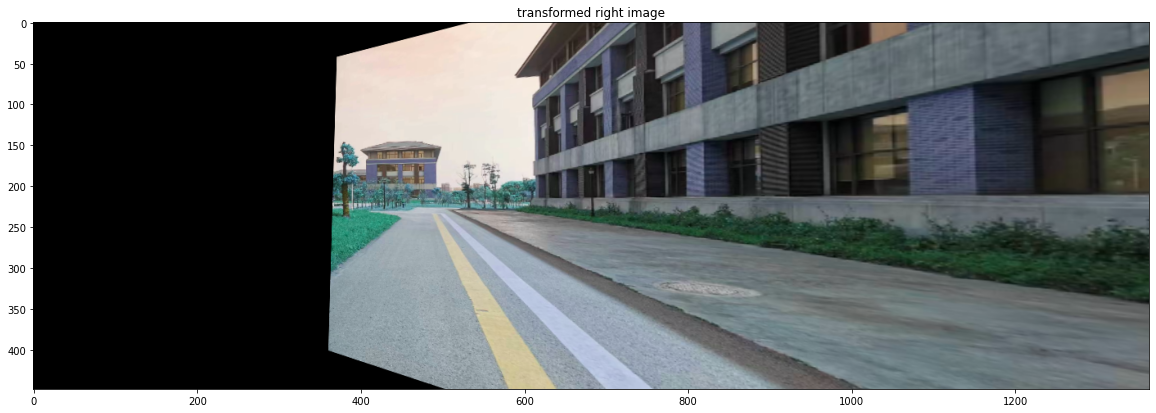

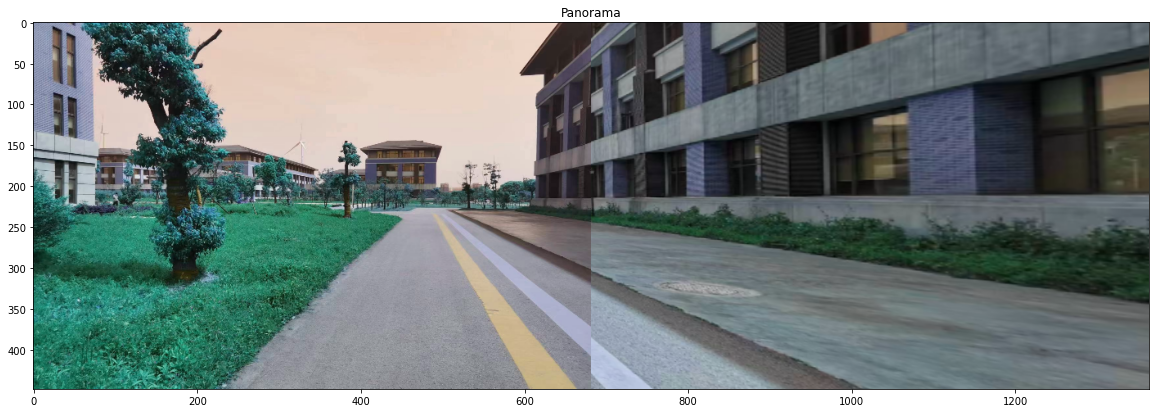

In [15]:
# 把图片拼接成全景图并保存
Panorama = Panorama_stitching(image_right, image_left)
# cv2.namedWindow("全景图", cv2.WINDOW_AUTOSIZE)
cv2.imwrite("全景图.jpg", Panorama)
plt.rcParams["figure.figsize"] = (20, 10)
plt.title('Panorama')
plt.imshow(Panorama)
plt.show()